In [162]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
import albumentations as A
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [113]:
class MyDataset(Dataset):
    def __init__(self,
                 images_folder,
                 transform=None,
                 *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.images_folder = images_folder

        self.transform = transform if transform else \
            A.Compose(
                [
                    ToTensorV2(),
                ]
            )
        self.model_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

        self.images_paths = []
        self._read_images_names()

    def _read_images_names(self):
        for root, dirs, files in os.walk(self.images_folder):
            for image_name in files:
                img_path = os.path.join(root, image_name)

                _, ext = os.path.splitext(img_path)
                if ext not in ['.png', '.jpg', '.jpeg']:
                    continue

                self.images_paths.append(img_path)

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        filepath = self.images_paths[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.transform(image=image)["image"]
        image = self.model_transform(image)

        return image.float()

In [119]:
my_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/faces_datasets/ds1")

In [120]:
len(my_dataset)

70000

In [91]:
class EmbeddingsExtractor(pl.LightningModule):

    def __init__(self):
        super(EmbeddingsExtractor, self).__init__()

        self.model = resnet18(weights=ResNet18_Weights)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
        )

        for name, param in self.model.named_parameters():
            # if "fc" in name or "layer4" in name or "layer3" in name:
            #     continue
            param.requires_grad = False

        # self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

    def get_embedings(self, dataset):
        dataloader = DataLoader(dataset, batch_size=16)
        self.eval()
        embeds = []
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(self.device)
                outputs = self(batch)
                embeds.append(outputs)
        return torch.cat(embeds)

In [140]:
import torch.utils
import torch.utils.data


def get_embeds_example(dataset, extractor, subsample_size=1_000, random_seed=42):
    np.random.seed(random_seed)
    idxs = np.random.choice(range(len(dataset)), subsample_size, True)
    subset = torch.utils.data.Subset(dataset, idxs)
    
    embeds = extractor.get_embedings(subset)
    return embeds

In [141]:
get_embeds_example(my_dataset, extractor, 10).shape

torch.Size([10, 512])

In [143]:
embeds1, embeds2 = get_embeds_example(my_dataset, extractor, random_seed=42), get_embeds_example(my_dataset, extractor, random_seed=69)

In [208]:
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error as mse
from itertools import product

def _mean_similarity(emb1, emb2):

    sim_sum = 0
    for el1 in emb1:
        for el2 in emb2:
            sim_sum += np.dot(el1, el2) / (np.linalg.norm(el1) * np.linalg.norm(el2))
    
    return sim_sum / len(emb1) / len(emb2)


def embeds_list_similarity(emb1, emb2):
    emb1, emb2 = np.array(emb1), np.array(emb2)

    return np.mean(_mean_similarity(emb1, emb2)) / 2 + np.mean(_mean_similarity(emb2, emb1)) / 2

In [212]:
embeds_list_similarity(embeds1, embeds2)

0.7159892408609391

In [213]:
def get_similarities(ds1, ds2, subsample_size=100):
    similarities_list = []
    for seed in tqdm(range(100)):
        embeds1, embeds2 = get_embeds_example(
            ds1, extractor, random_seed=seed, subsample_size=subsample_size), get_embeds_example(
                ds2, extractor, random_seed=seed**2, subsample_size=subsample_size)
        similarities_list.append(embeds_list_similarity(embeds1, embeds2))
    return similarities_list

In [214]:
similarities_list = get_similarities(my_dataset, my_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 1.,  0.,  1.,  2.,  7., 14., 12., 10., 17., 13.,  6.,  6.,  7.,
         1.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([0.71598924, 0.71780037, 0.71961151, 0.72142264, 0.72323377,
        0.72504491, 0.72685604, 0.72866717, 0.7304783 , 0.73228944,
        0.73410057, 0.7359117 , 0.73772284, 0.73953397, 0.7413451 ,
        0.74315623, 0.74496737, 0.7467785 , 0.74858963, 0.75040077,
        0.7522119 ]),
 <BarContainer object of 20 artists>)

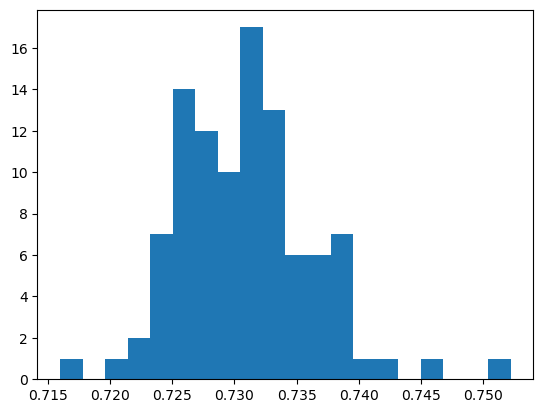

In [215]:
plt.hist(similarities_list, bins=20)

In [216]:
test_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/faces_datasets/ds2")
len(test_dataset), len(my_dataset)

(12000, 70000)

In [217]:
similarities_test_list = get_similarities(my_dataset, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 4.,  5.,  2.,  1.,  6.,  9.,  7.,  6.,  3., 11., 10.,  5.,  7.,
         9.,  7.,  4.,  1.,  2.,  0.,  1.]),
 array([0.67881234, 0.68005977, 0.6813072 , 0.68255464, 0.68380207,
        0.6850495 , 0.68629693, 0.68754437, 0.6887918 , 0.69003923,
        0.69128666, 0.69253409, 0.69378153, 0.69502896, 0.69627639,
        0.69752382, 0.69877126, 0.70001869, 0.70126612, 0.70251355,
        0.70376098]),
 <BarContainer object of 20 artists>)

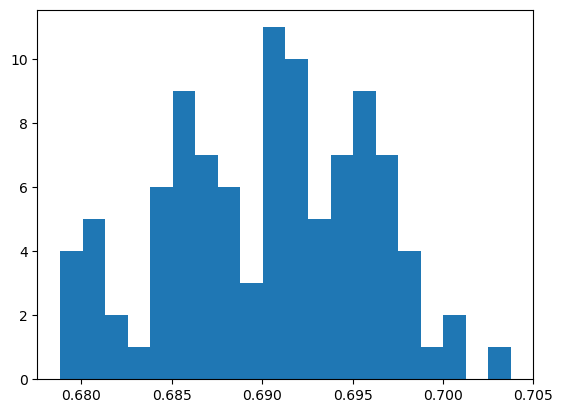

In [218]:
plt.hist(similarities_test_list, bins=20)